# Notebook 09: Interpretation of a trained ML model

### Goal: Show some examples of how to interogate a trained ML model

#### Background

While alot of this tutorial has been working up to training and evaluating a ML model they can still seem a bit like a black box. In order to help unvail some things that the ML model has learned, we will do a few *explination* methods on the ML here. Specifically, we will show an example of *permuation importance* and the *accumulated local effects*. Both of these methods were discussed in the paper and are already coded up for you in the ```scikit-explain``` python package maintained by Dr. Flora at CIWRO [link](https://github.com/monte-flora/scikit-explain). These methods will help us understand what the ML learning has learned and give us some clues to the decision proccess it uses.

In order to save some time in setting up python, I did not include this package in the original install. So to install if please activate your ```waf_tutorial_part1``` enviornment

```$ conda activate waf_tutorial_part1 ``` 

then pip install the ```scikit-explain```

```$ pip install scikit-explain``` 

If when importing the next cell you get an error with importing matplotlib (something about a multiindex), upgrade matplotlib 

```$ pip install -U matplotlib``` 

# Load presaved model + Training Data 
You will need this cell for both the Permutation Importantance and the Accumulated Local Effects methods!

In notebook 4 and 5, we showed you how to save/load the simple ML model. Feel free to change the path to that file if you wish to see your model results. If not, leave the file path as is to see the trained models in the paper (without SVM because there is no ```predict_proba``` method, which is needed).

Just like the paper, we will start with the classification models. We also need the training data to do the investigations, so lets load that in too

In [1]:
import matplotlib.pyplot as plt
#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'


###################################### Load trained models ######################################
import joblib
names = ['LogisticRegression.pkl','NaiveBayes.pkl','DecisionTree.pkl','RandomForest.pkl','GradientBoostedTrees.pkl',]
start_path = '../datasets/sklearnmodels/classification/allfeatures/'
model_list = []

for name in names:
    #notice the change from wb to rb 
    savefile = open(start_path + name,'rb')
    #notice the change from dump to load 
    model_list.append(joblib.load(savefile))
    
print(model_list)
################################################################################################

###################################### Load training data ######################################
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')
from aux_functions import load_n_combine_df
import numpy as np
(X_train,y_train),(X_validate,y_validate),_ = load_n_combine_df(path_to_data='../datasets/sevir/',features_to_keep=np.arange(0,36,1),class_labels=True)

#remember since we have all 36 predictors we need to scale the inputs 
from sklearn.preprocessing import StandardScaler
#create scaling object 
scaler = StandardScaler()
#fit scaler to training data
scaler.fit(X_train)
#transform feature data into scaled space 
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)
################################################################################################


[LogisticRegression(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]


We do need to do a small adjustment to our training data. The ```skexplain``` expects a dataframe with the names of each column. So we have gone ahead and provided a list of names for each column in the next cell. The *q* stands for quantile and then the number is the percentile that it is (where 0 is the min and 100 is the max). Then the *_* shows which variable it is (ir=='infrared',wv=='water vapor',vi=='visible',vl=='VIL')

In [2]:
import pandas as pd
column_names = ['q000_ir',
 'q001_ir',
 'q010_ir',
 'q025_ir',
 'q050_ir',
 'q075_ir',
 'q090_ir',
 'q099_ir',
 'q100_ir',
 'q000_wv',
 'q001_wv',
 'q010_wv',
 'q025_wv',
 'q050_wv',
 'q075_wv',
 'q090_wv',
 'q099_wv',
 'q100_wv',
 'q000_vi',
 'q001_vi',
 'q010_vi',
 'q025_vi',
 'q050_vi',
 'q075_vi',
 'q090_vi',
 'q099_vi',
 'q100_vi',
 'q000_vl',
 'q001_vl',
 'q010_vl',
 'q025_vl',
 'q050_vl',
 'q075_vl',
 'q090_vl',
 'q099_vl',
 'q100_vl']

X_df = pd.DataFrame(X_train,columns=column_names)
X_df.head()

,q000_ir,q001_ir,q010_ir,q025_ir,q050_ir,q075_ir,q090_ir,q099_ir,q100_ir,q000_wv,...,q100_vi,q000_vl,q001_vl,q010_vl,q025_vl,q050_vl,q075_vl,q090_vl,q099_vl,q100_vl
0,-0.496423,-0.680095,-0.856844,-1.097814,-1.423917,-1.672151,-1.768832,-1.119766,0.037698,-0.460695,...,0.893267,-0.075823,-0.077287,-0.081944,-0.091565,-0.082707,0.066050,0.240730,0.102245,-0.155187
1,-0.529877,-0.663451,-0.860079,-1.094734,-1.454247,-1.726129,-1.780010,-1.303199,0.048498,-0.523225,...,0.795447,-0.075823,-0.077287,-0.081944,-0.091565,-0.081446,0.071456,0.252634,0.120325,0.142743
2,-0.487918,-0.653048,-0.859155,-1.096054,-1.476102,-1.779606,-1.795068,-1.441299,0.073422,-0.482621,...,0.837465,-0.075823,-0.077287,-0.081944,-0.091565,-0.078721,0.077002,0.264849,0.120325,0.024547
3,-0.514568,-0.649927,-0.860542,-1.101774,-1.483685,-1.834083,-1.796052,-1.446845,-0.038735,-0.482621,...,0.818790,-0.075823,-0.077287,-0.081944,-0.091565,-0.075701,0.077002,0.252634,0.102245,-0.244270
4,-0.516836,-0.647327,-0.862390,-1.107495,-1.485469,-1.863571,-1.808215,-1.456752,-0.678445,-0.498863,...,0.910163,-0.075823,-0.077287,-0.081944,-0.091565,-0.075701,0.077002,0.240730,0.084625,-0.492888


okay, our data is ready then to use the ```skexplain``` package. Both methods discussed will use the method named ```ExplainToolkit()``` where the inputs are your trained models ```estimators``` and your data ```X```,```y```

In [3]:
import skexplain

estimators = estimators = [('LogisticRegression',model_list[0]),('NaiveBayes',model_list[1]),('DecisionTree',model_list[2]),('RandomForest',model_list[3]),('GradientBoostedTrees',model_list[4])]
explainer = skexplain.ExplainToolkit(estimators=estimators, X=X_df, y=y_train,)
                                                               

Now that the main explainer object is defined, we will calcualte the permuation importance. 

# Permutation Importance

### Single Pass permutation importance

Here is a good animation of what single pass permuation importance does. Click the image to take you to the page source.

<a href=https://permutationimportance.readthedocs.io/en/latest/methods.html#permutation-importance> <img alt="Animation of singlepass permutation importance" src="https://permutationimportance.readthedocs.io/en/latest/_images/SinglePassPermutation.gif"> </a>


Each predictor (i.e., feature) is shuffled to see how it impacts some sort of metric (i.e., loss/error). For our example we use the AUC of the ROC curve, like we dicussed in the paper. The intuition is that the most important predictor will be the one that *hurts* the model performance the most when it is shuffled (i.e., randomized). 

### Multipass permutation importance

Unfortunately, there are alot of correlations between input predictors in most datasets. So single pass permuation importance might not show use the true value of some inputs because the prediction power might be split across the highly correlated features. One way around that is to do a mult-pass permutation importance. 

<a href=https://permutationimportance.readthedocs.io/en/latest/methods.html#permutation-importance> <img alt="Animation of multipass permutation importance" src="https://permutationimportance.readthedocs.io/en/latest/_images/MultiPassPermutation.gif"> </a>


So as you can see in the gif, we first permutate all of them (like single pass), find the max change to the loss, then we freeze the shuffled variable that caused the largest change. From there, we shuffle the variables that are left. we repeat this until you get the disired number of variables (above we chose 5). This is called the *backward permuation importance*. You can do this same methodology but in the forward direction. In other words, you can start with them all shuffled, and un-permute them, to see how much *better* the AUC score becomes. 

Note that it does take a decent amount of computational time to do this test (on my mac it took a couple hours just to do 5 variables). So if you can do this in parallel (i.e., how many cpus does your machine have?) change ```n_jobs``` to something > 1 (i set mine to 2). But if you do n_jobs=1, maybe go make a cup of tea and grab a snack. The code block will save it to a netcdf file so you dont have to recalculate this again late. 

In fact, we have already saved the result of this cell block, so you dont even have to run it to jump to plotting it! (skip this cell and just go to the next one where we load the saved data)


In [4]:
#run permutation importance! we will assume AUC of the ROC curve as our metric. 
results_backward = explainer.permutation_importance(n_vars=5,evaluation_fn='auc', n_permute=10, subsample=0.25,n_jobs=2,verbose=True,random_seed=42, 
                                           direction='backward',)

#Save the permutation importance results as a netcdf file using the bulit-in function 
explainer.save(fname='../datasets/explanations/multipass_importance_auc_backward.nc', data=results_backward)

results_forward = explainer.permutation_importance(n_vars=5,evaluation_fn='auc', n_permute=10, subsample=0.25,n_jobs=2,verbose=True,random_seed=42, 
                                           direction='forward',)

#Save the permutation importance results as a netcdf file using the bulit-in function 
explainer.save(fname='../datasets/explanations/multipass_importance_auc_forward.nc', data=results_forward)

Multi-pass iteration 1 out of 5...



KeyboardInterrupt



Please run this cell whether you run the above cell or not.

In [4]:
#create explainer object
explainer = skexplain.ExplainToolkit()
# Load the results file into the explainer object
results_backward = explainer.load(fnames='../datasets/explanations/multipass_importance_auc_backward.nc')
results_forward = explainer.load(fnames='../datasets/explanations/multipass_importance_auc_forward.nc')

Good, now we can plot it up. To do this, we will use the stock ```plot_importance``` method built within ```skexplain```. To start off simple, let us look at the logistic regression we trainined (like the one in Notebook 6 and 8)

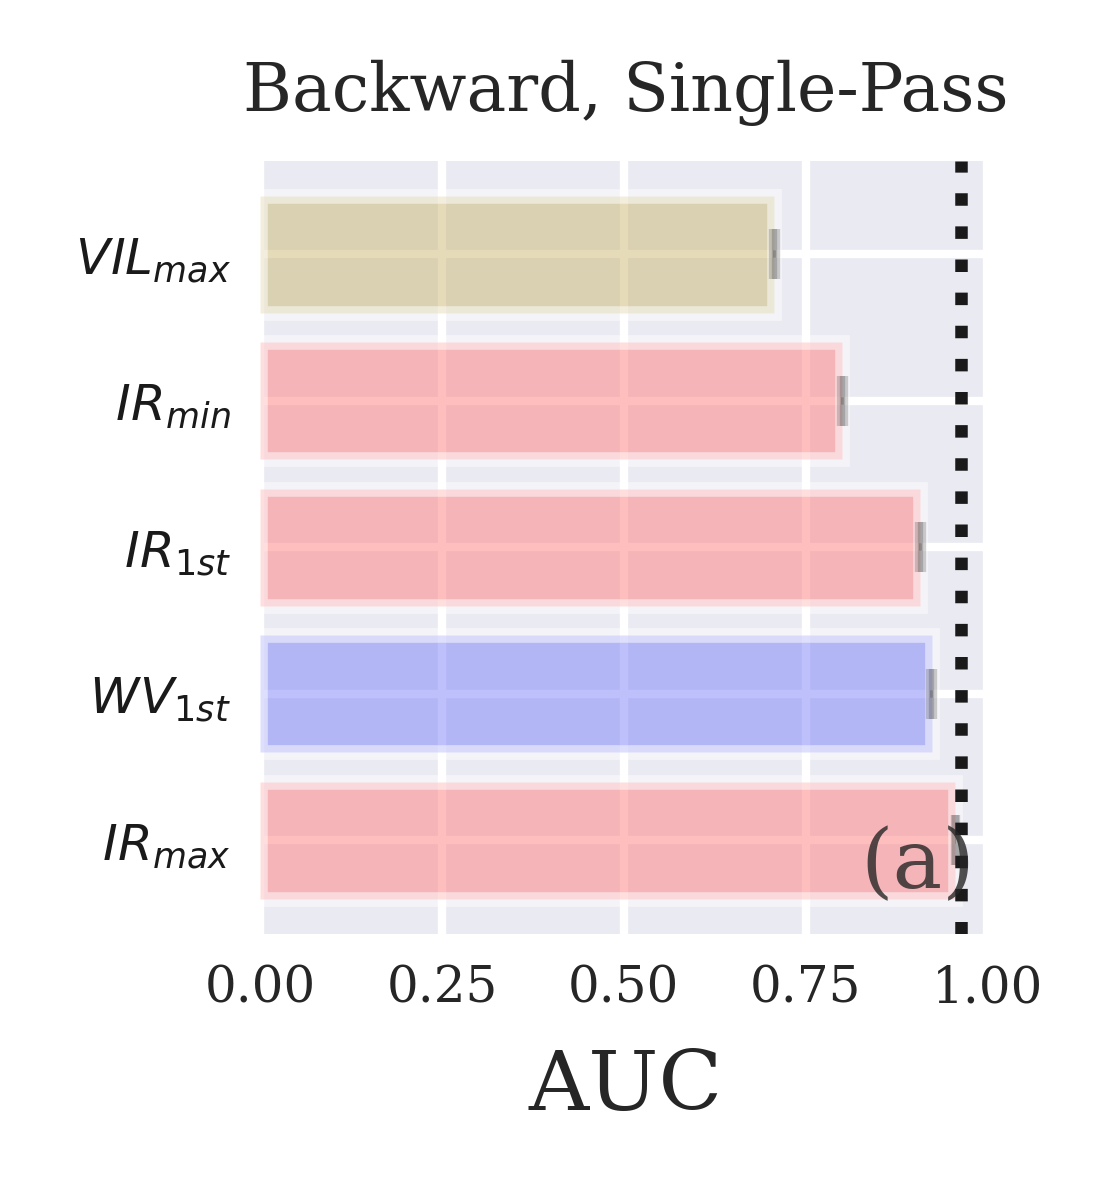

In [5]:
#import some helpful descriptors 
from aux_functions import display_feature_names,color_dict

#use the plot_importance method. it takes the result of the permuation test, whatever panels you want to make, then the number of bars you want. 
fig,ax = explainer.plot_importance(data=results_backward, 
                                panels=[('singlepass', 'LogisticRegression')], 
                                num_vars_to_plot=5,figsize=(2,2),xlabels=['AUC'],
                                display_feature_names=display_feature_names,
                               feature_colors=color_dict)

#add the original AUC score to see how much it changes when we shuffle a feature
ax.set_title('Backward, Single-Pass')
ax.axvline(results_backward.original_score__LogisticRegression.mean(),color='k',ls=':');

The x-axis is the AUC value (of the ROC curve), while the dashed black line shows the AUC value with the training data as is (i.e., no shuffline). The bars then show the AUC when we shuffle that feature (labeled on the y-axis) and leave all others features alone. We have ordered these based on the largest reduction of AUC is at the top, implying the most important feature. The colors correspond to the variable, yellow is for the radar measured quantities (VIL), red is for infrared, blue is for water vapor and grey/black is for visible. 

We can see here that the 100th percentile (i.e., max) of vertically integrated liquid (VIL; $\mathrm{VIL_{max}}$) is the most important predictor, reducing AUC by about 0.2. The fact that VIL is the top predictors makes sense meteorologically since the radar is deriving the amount of liquid water inside the profile, which has been already linked to lightning ([Watson et al. 1995](https://journals.ametsoc.org/view/journals/wefo/10/3/1520-0434_1995_010_0592_lftndn_2_0_co_2.xml)). The second most important is the minimum clean infrared brightness temperature ($\mathrm{IR_{min}}$), which also makes sense meteorologically given that deeper (i.e., stronger) convection has colder infrared brightness temperatures. After that the next important features are the first percentile of infrared (probably very similiar to the minimum) and the first percentile of water vapor. But as you can see, there is very little drop in AUC when $\mathrm{IR_{1st}}$, $\mathrm{WV_{1st}}$ and $\mathrm{IR_{max}}$ are shuffled. 

Above was the result of starting with the data unpermuated, then going ahead and permuting each feature one at a time (named the backward method). Now if we do the opposite, and start with all variables shuffled, and unshuffle one feature at a time does it show us the same importance order?

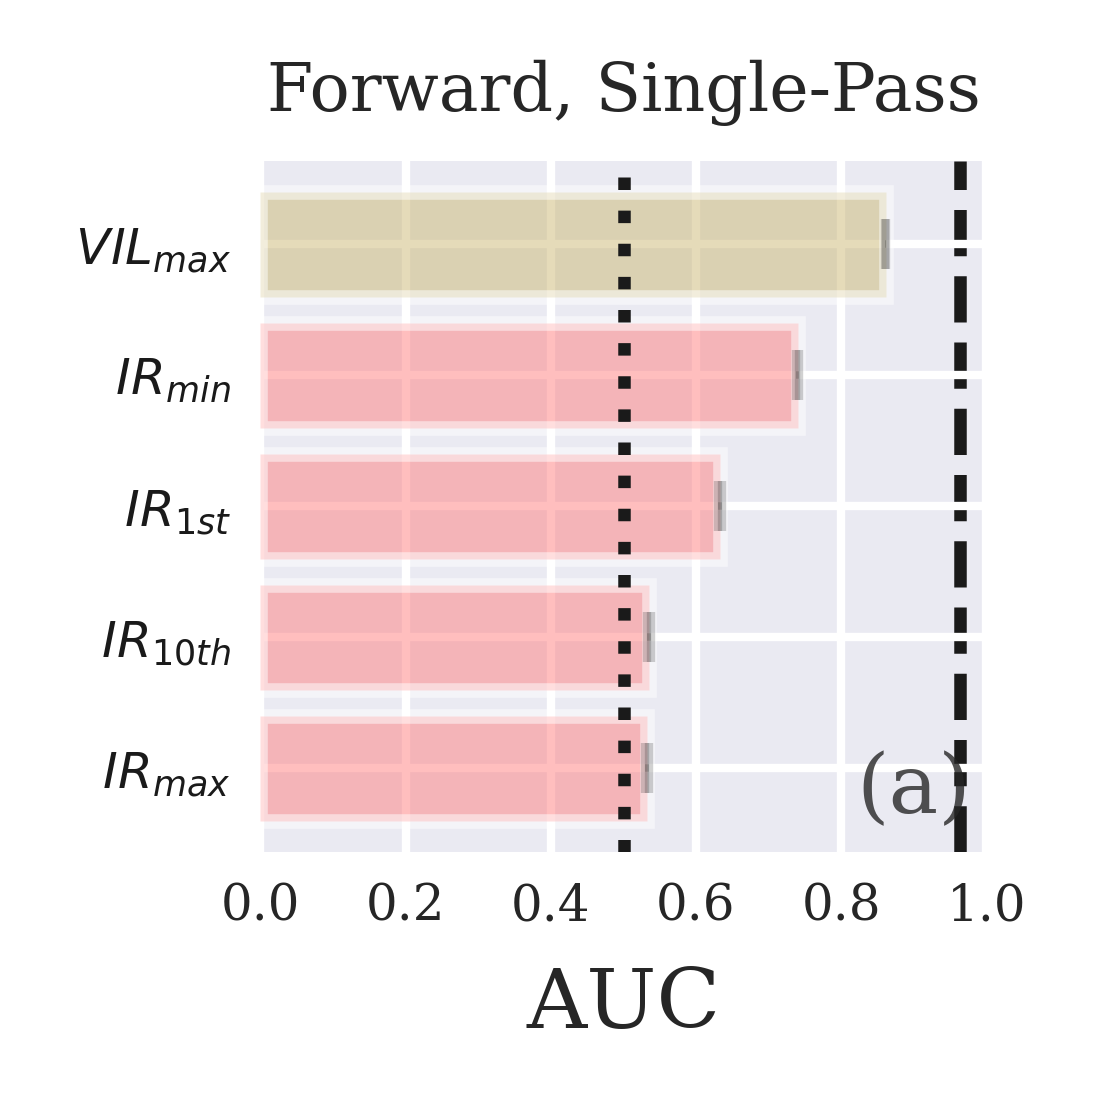

In [7]:
#use the plot_importance method. it takes the result of the permuation test, whatever panels you want to make, then the number of bars you want. 
fig,ax = explainer.plot_importance(data=results_forward, 
                                panels=[('singlepass', 'LogisticRegression')], 
                                num_vars_to_plot=5,figsize=(2,2),xlabels=['AUC'],
                                display_feature_names=display_feature_names,
                               feature_colors=color_dict)

#add the original AUC score to see how much it changes when we shuffle a feature
ax.set_title('Forward, Single-Pass')
ax.axvline(results_forward.original_score__LogisticRegression.mean(),color='k',ls='--',zorder=0);
ax.axvline(results_forward.all_permuted_score__LogisticRegression.mean(),color='k',ls=':');
ax.set_xlim([0,1])
plt.tight_layout()

Same as the last one, the xaxis is the AUC value. But this time the dotted black line shows the AUC when all the training data are shuffled. The dashed black line is still the original score of the model (with all the features normal). The bars then show the AUC when we **un**shuffle that feature (labeled on the y-axis) and all other features remain shuffled. We have ordered these based on the largest increase of AUC is at the top. 

The results are effectively the same. THe only difference is now $\mathrm{IR_{10th}}$ is the fourth most important. But keep in mind again, that the difference of all of them shuffled (dotted line) and just $\mathrm{IR_{10th}}$ only improves the AUC slightly. 

As we stated before, the correlation between predictors could be skewing the results of doing the single-pass importance. Let's take a look at the multi-pass. As a reminder, the multi-pass does the single pass first, finds the largest change to AUC, then leaves that predictor shuffled. Then it does the single pass again on the new set of features, finds the max change in AUC again and leaves that one shuffled and so on (this is called backward multipass).

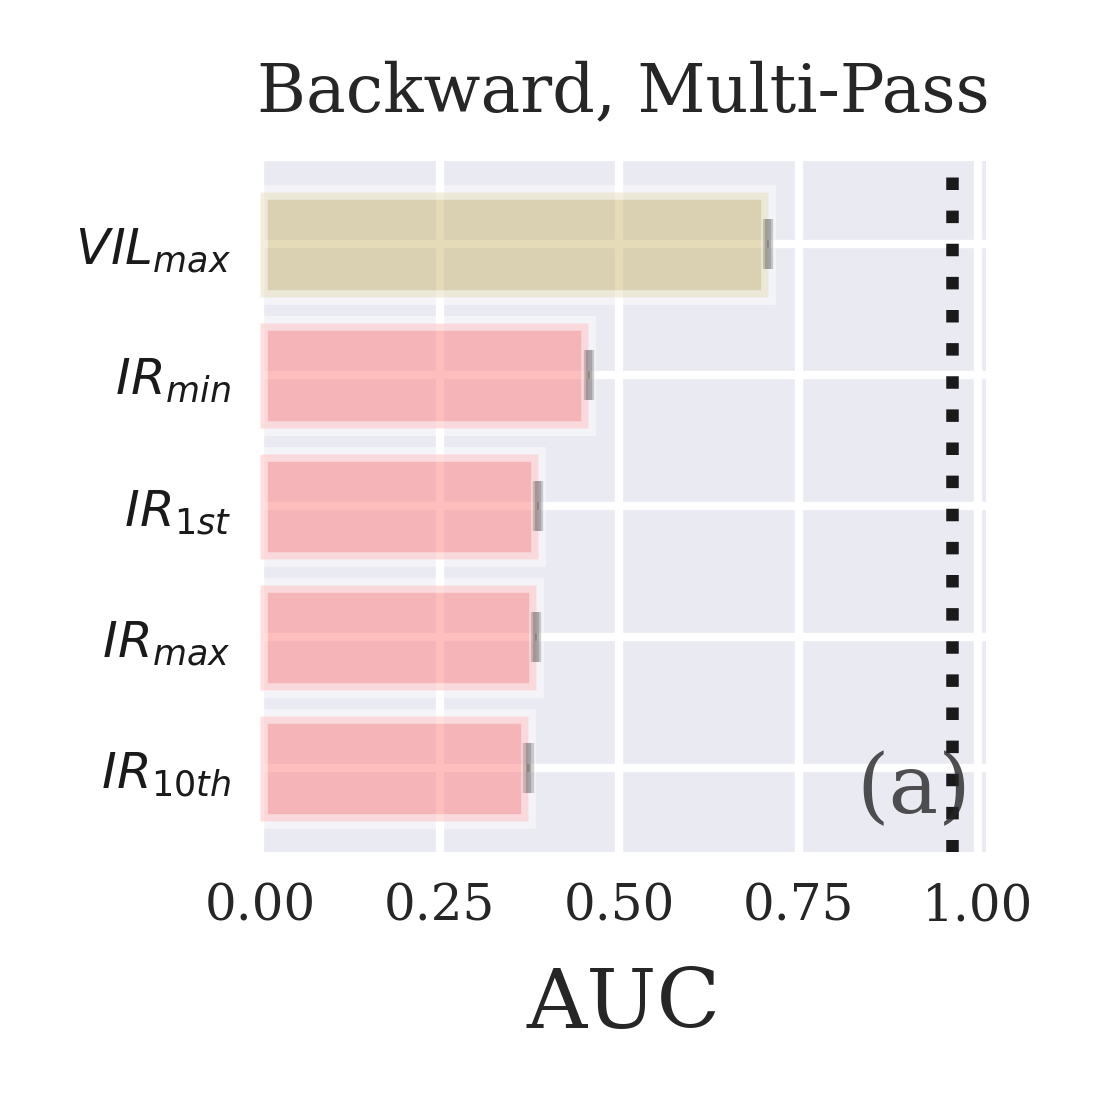

In [6]:
#use the plot_importance method. it takes the result of the permuation test, whatever panels you want to make, then the number of bars you want. 
fig,ax = explainer.plot_importance(data=results_backward, 
                                panels=[('multipass', 'LogisticRegression')], 
                                num_vars_to_plot=5,figsize=(2,2),xlabels=['AUC'],
                                display_feature_names=display_feature_names,
                               feature_colors=color_dict)

#add the original AUC score to see how much it changes when we shuffle a feature
ax.set_title('Backward, Multi-Pass')
ax.axvline(results_backward.original_score__LogisticRegression.mean(),color='k',ls=':');
plt.tight_layout()

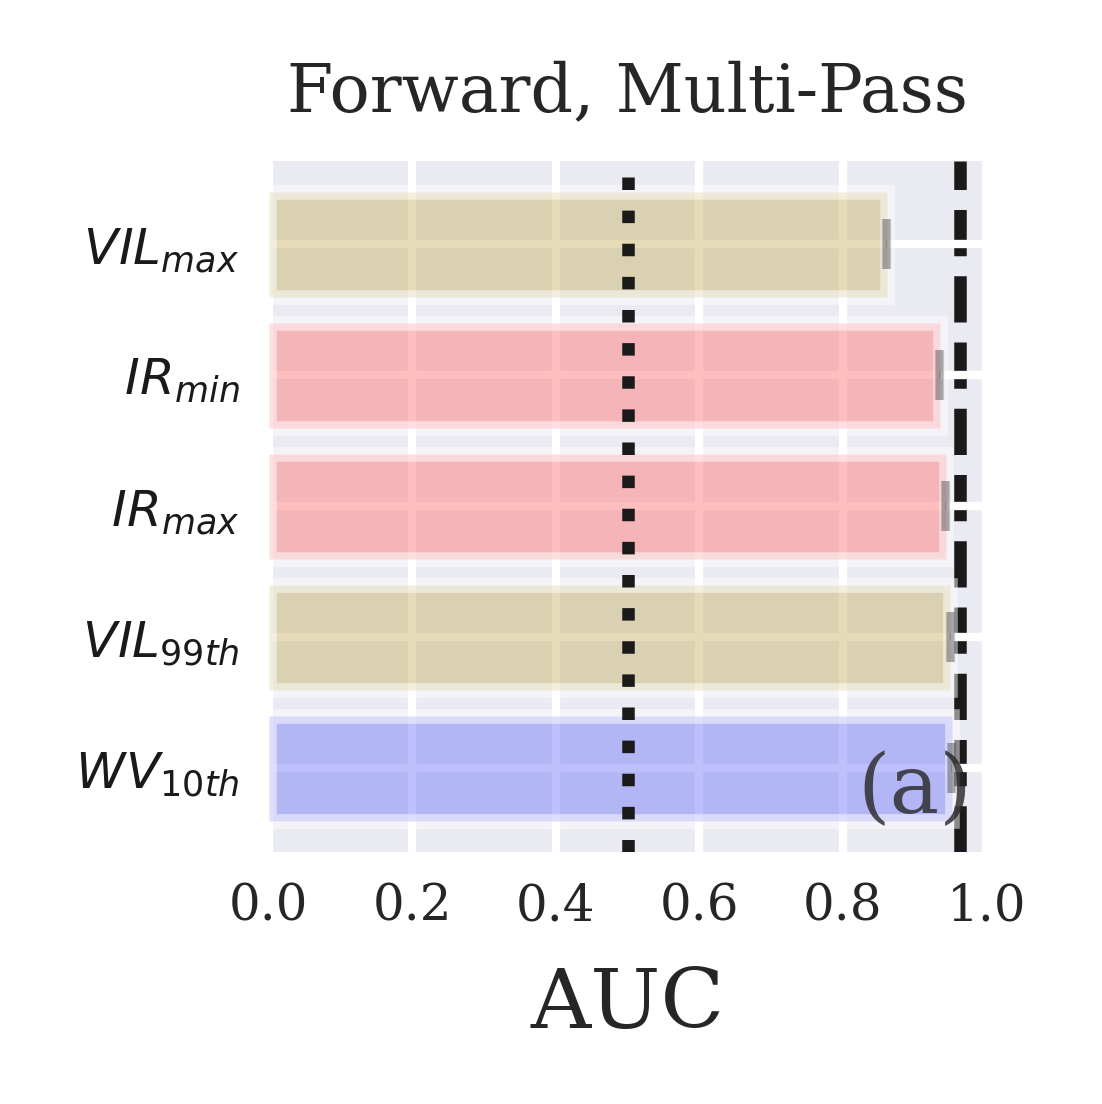

In [9]:
#use the plot_importance method. it takes the result of the permuation test, whatever panels you want to make, then the number of bars you want. 
fig,ax = explainer.plot_importance(data=results_forward, 
                                panels=[('multipass', 'LogisticRegression')], 
                                num_vars_to_plot=5,figsize=(2,2),xlabels=['AUC'],
                                display_feature_names=display_feature_names,
                               feature_colors=color_dict)

#add the original AUC score to see how much it changes when we shuffle a feature
ax.set_title('Forward, Multi-Pass')
ax.axvline(results_forward.original_score__LogisticRegression.mean(),color='k',ls='--',zorder=0);
ax.axvline(results_forward.all_permuted_score__LogisticRegression.mean(),color='k',ls=':');
ax.set_xlim([0,1])
plt.tight_layout()

Same as the single-pass forward results. It would seem the same features are indicated as important. Let's try the backward method

These are mostly the same, until the 5th one. Interestingly, the ```q100_ir``` (the **max** infrared brightness temperature) is the 5th most important. This could make sense since the maximum brightness temperature is likely some sort of proxy for the surface temperature. 

How do we reconcile all these results? In general you want to take the consensus, which points to the max VIL being the most important predictor when training a random forest with all features. 

One cool thing about ```skexplain```, is that we can easily show more than 1 model and more than one test. So lets take a look at the top 5 features for logistic regression, random forest and gradient boosted trees. Specifically, lets look at the foreward test. 

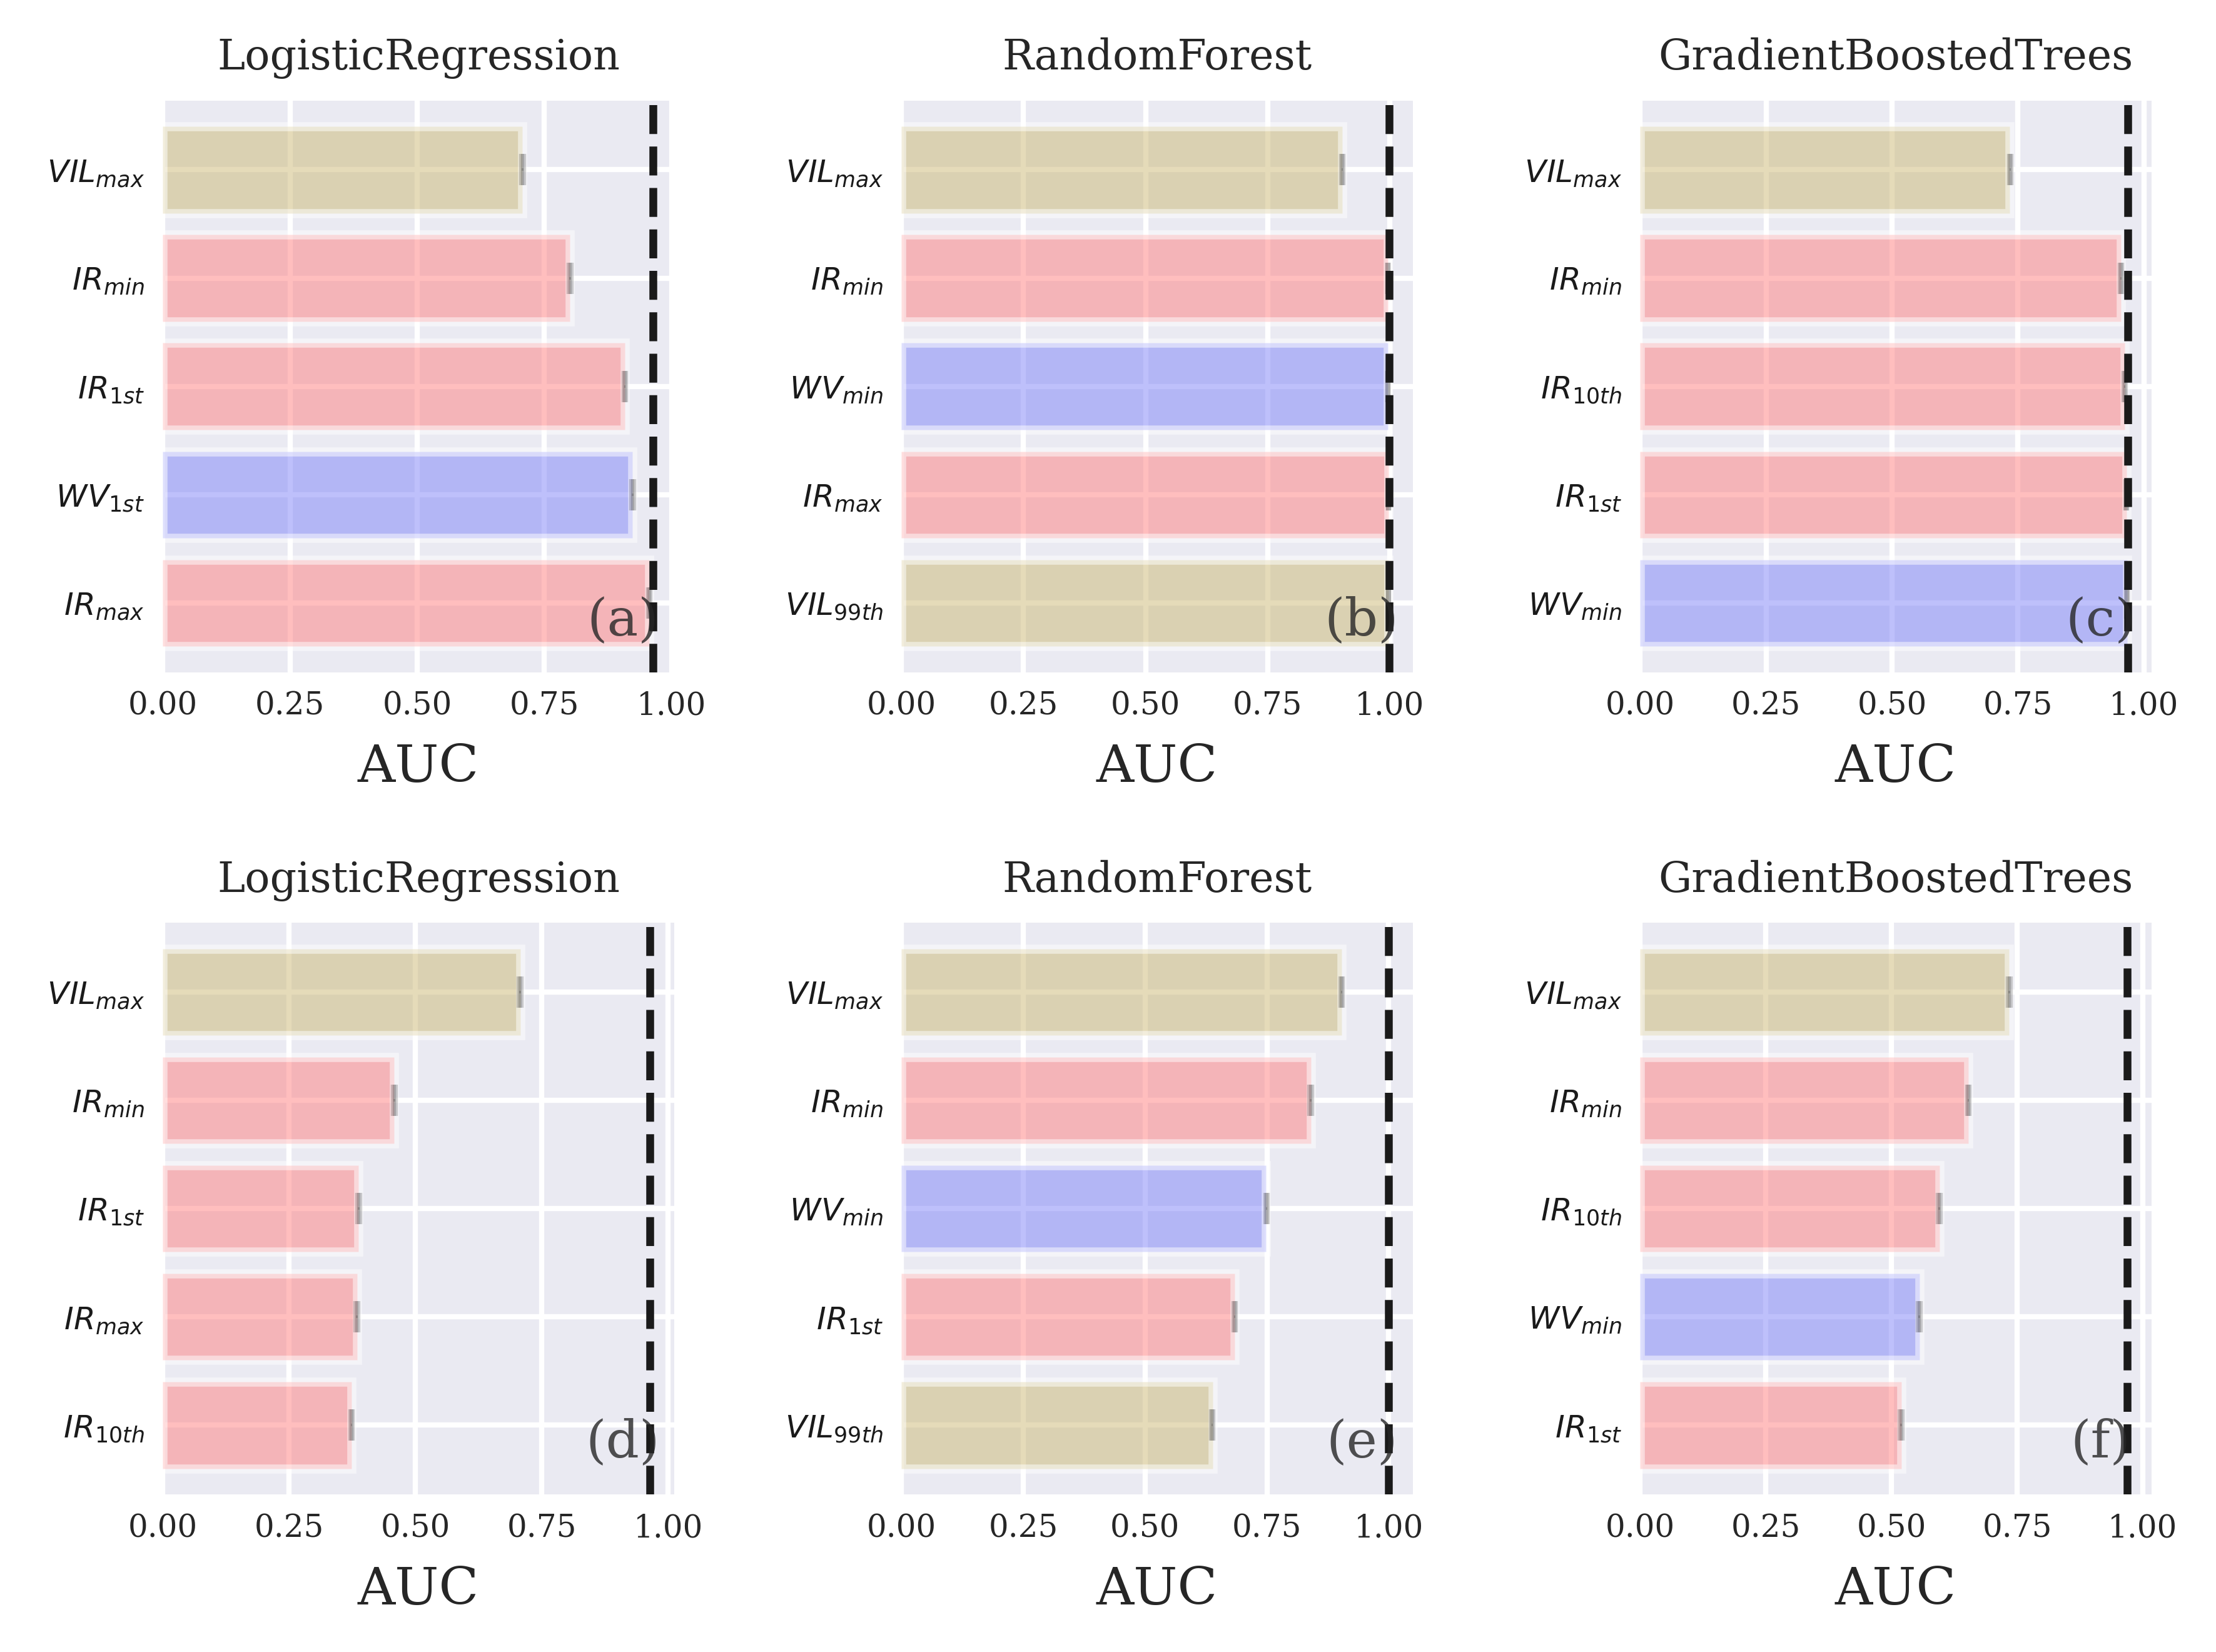

In [11]:
panels=[('singlepass', 'LogisticRegression'), 
                                        ('singlepass', 'RandomForest'), 
                                        ('singlepass', 'GradientBoostedTrees'),
                                        ('multipass', 'LogisticRegression'),
                                        ('multipass', 'RandomForest'),
                                        ('multipass', 'GradientBoostedTrees')]
                 
fig,axes = explainer.plot_importance(data=[results_backward]*6, 
                                panels=panels,
                                num_vars_to_plot=5,xlabels=['AUC']*6,
                               display_feature_names=display_feature_names,
                               feature_colors=color_dict)

axes = axes.ravel()
for i,ax in enumerate(axes):
    method = panels[i][1]
    ax.axvline(results_backward['original_score__' +method].mean(),color='k',ls='--')
    
fig.set_facecolor('w')

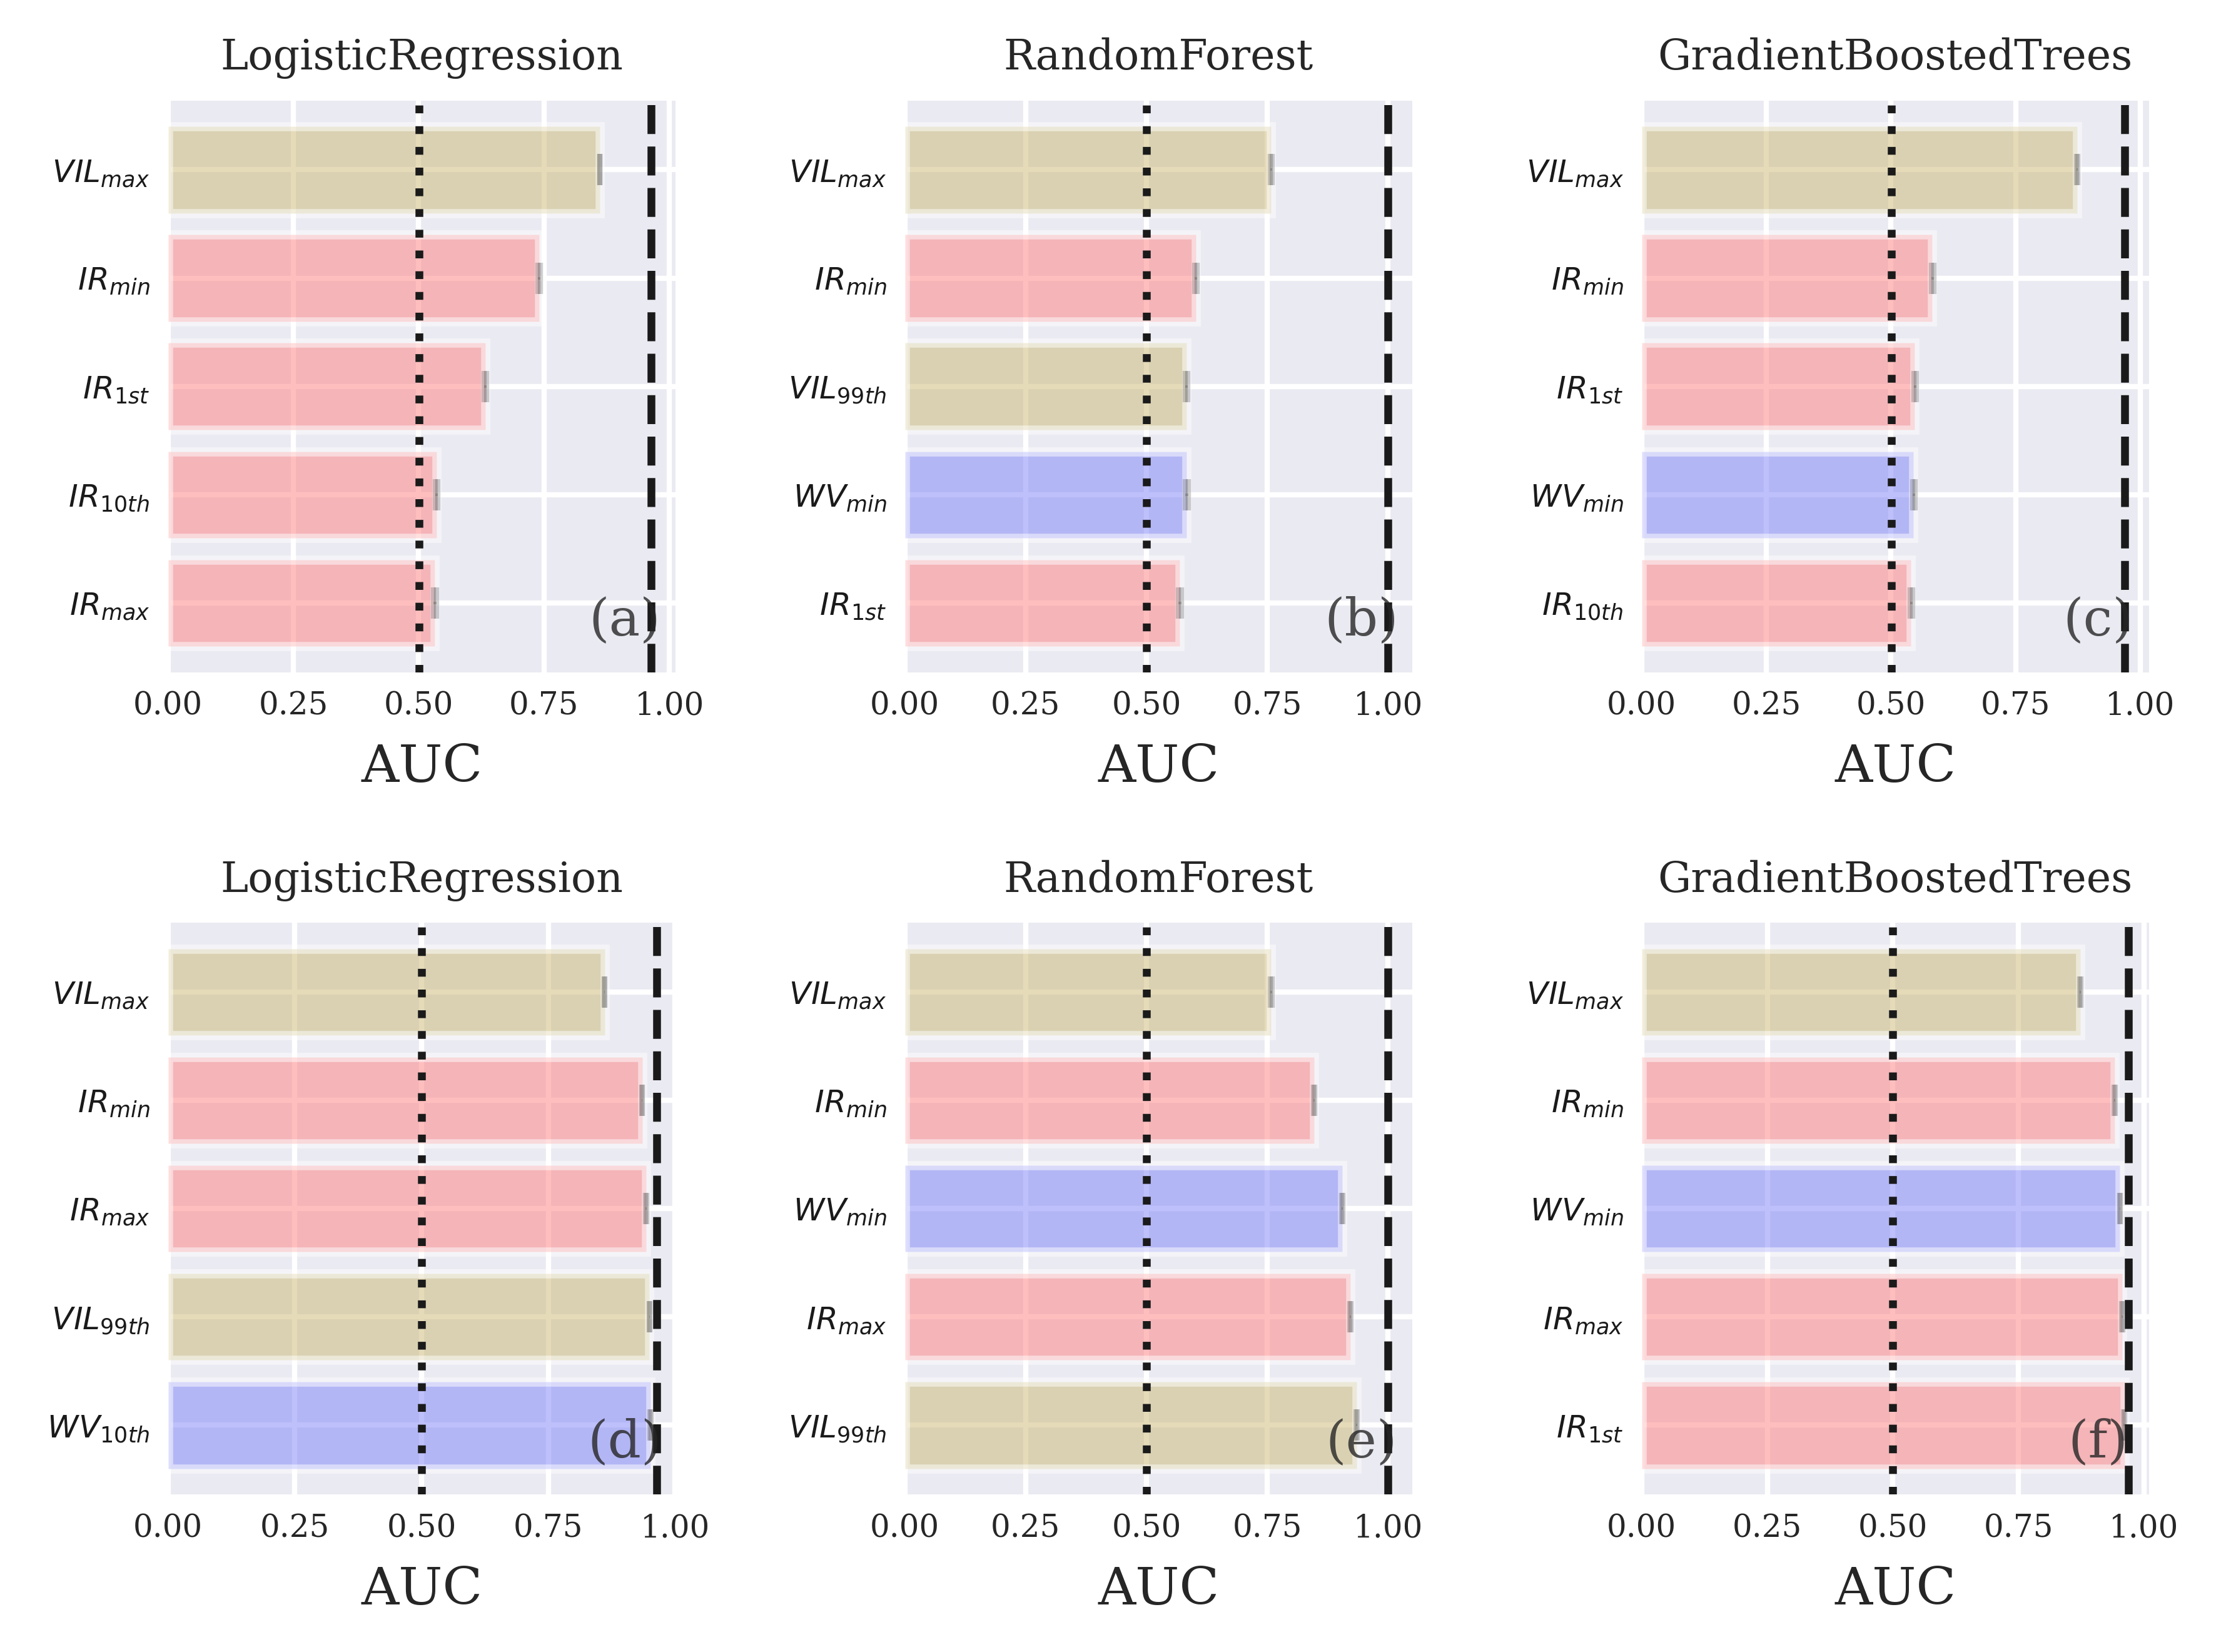

In [10]:
from aux_functions import display_feature_names,color_dict

panels=[('singlepass', 'LogisticRegression'), 
        ('singlepass', 'RandomForest'), 
        ('singlepass', 'GradientBoostedTrees'),
        ('multipass', 'LogisticRegression'),
        ('multipass', 'RandomForest'),
        ('multipass', 'GradientBoostedTrees')]
                 
fig,axes = explainer.plot_importance(data=[results_forward]*6, 
                                panels=panels,
                                num_vars_to_plot=5,xlabels=['AUC']*6,
                               display_feature_names=display_feature_names,
                               feature_colors=color_dict)

axes = axes.ravel()
for i,ax in enumerate(axes):
    method = panels[i][1]
    ax.axvline(results_forward['original_score__' +method].mean(),color='k',ls='--')
    ax.axvline(results_forward['all_permuted_score__' +method].mean(),color='k',ls=':');
    
fig.set_facecolor('w')

# Accumulated Local Effects (ALE) 

While permuation importance was useful in getting a glimpse at how the model was making decisions, it wasnt very quantitative in knowing how it uses each feature. We really only gained an understanding of what features were generally important. Something that is still desired would be "How does our ML change if we change the value of the $\mathrm{VIL_{max}}$? Does the prediciton go up or down with increasing $\mathrm{VIL_{max}}$?


To answer this type of question we will use the Accumulated Local Effects (ALE). While a bit too complicated to describe mathematically, know the intuition behind it. Basically we use the training data and break it down into bins, so for  $\mathrm{IR_{min}}$ we can break it into 5 degree temperature bins. We then ask, how does the prediction of our machine learning model change as we go from $-30^{\circ}$C to $-25^{\circ}$C. We can quantitaively get the change across this bin using the training database. We can then combine this with all other temperature bins to create a curve showing how the machine learning prediction changes as a function of this one feature. We can repeat this for all features, but for now, we will consider the general consensus of important features from the permuation importance test: $\mathrm{VIL_{max}}$, $\mathrm{IR_{min}}$, $\mathrm{WV_{min}}$

To calcualte the ALE we use the ```explainer.ale``` method. Unlike the last test, this code is realtively quick. 

In [39]:
#redefine estimators so we can just look at 1 machine learning model right now 
estimators = estimators = [('LogisticRegression',model_list[0])]
explainer = skexplain.ExplainToolkit(estimators=estimators, X=X_df, y=y_validate,)
#these are the keys for VIL_max, IR_min and WV_min
ale_1d_ds = explainer.ale(features=['q100_vl','q000_ir','q000_wv'],n_bootstrap=1,subsample=1000,n_jobs=1, n_bins=20)

  0%|          | 0/3 [00:00<?, ?it/s]

Now we can plot it up, using the ```explainer.plot_ale``` method.

Text(0.5, 0, '$WV_{min}$, [$\\sigma$]')

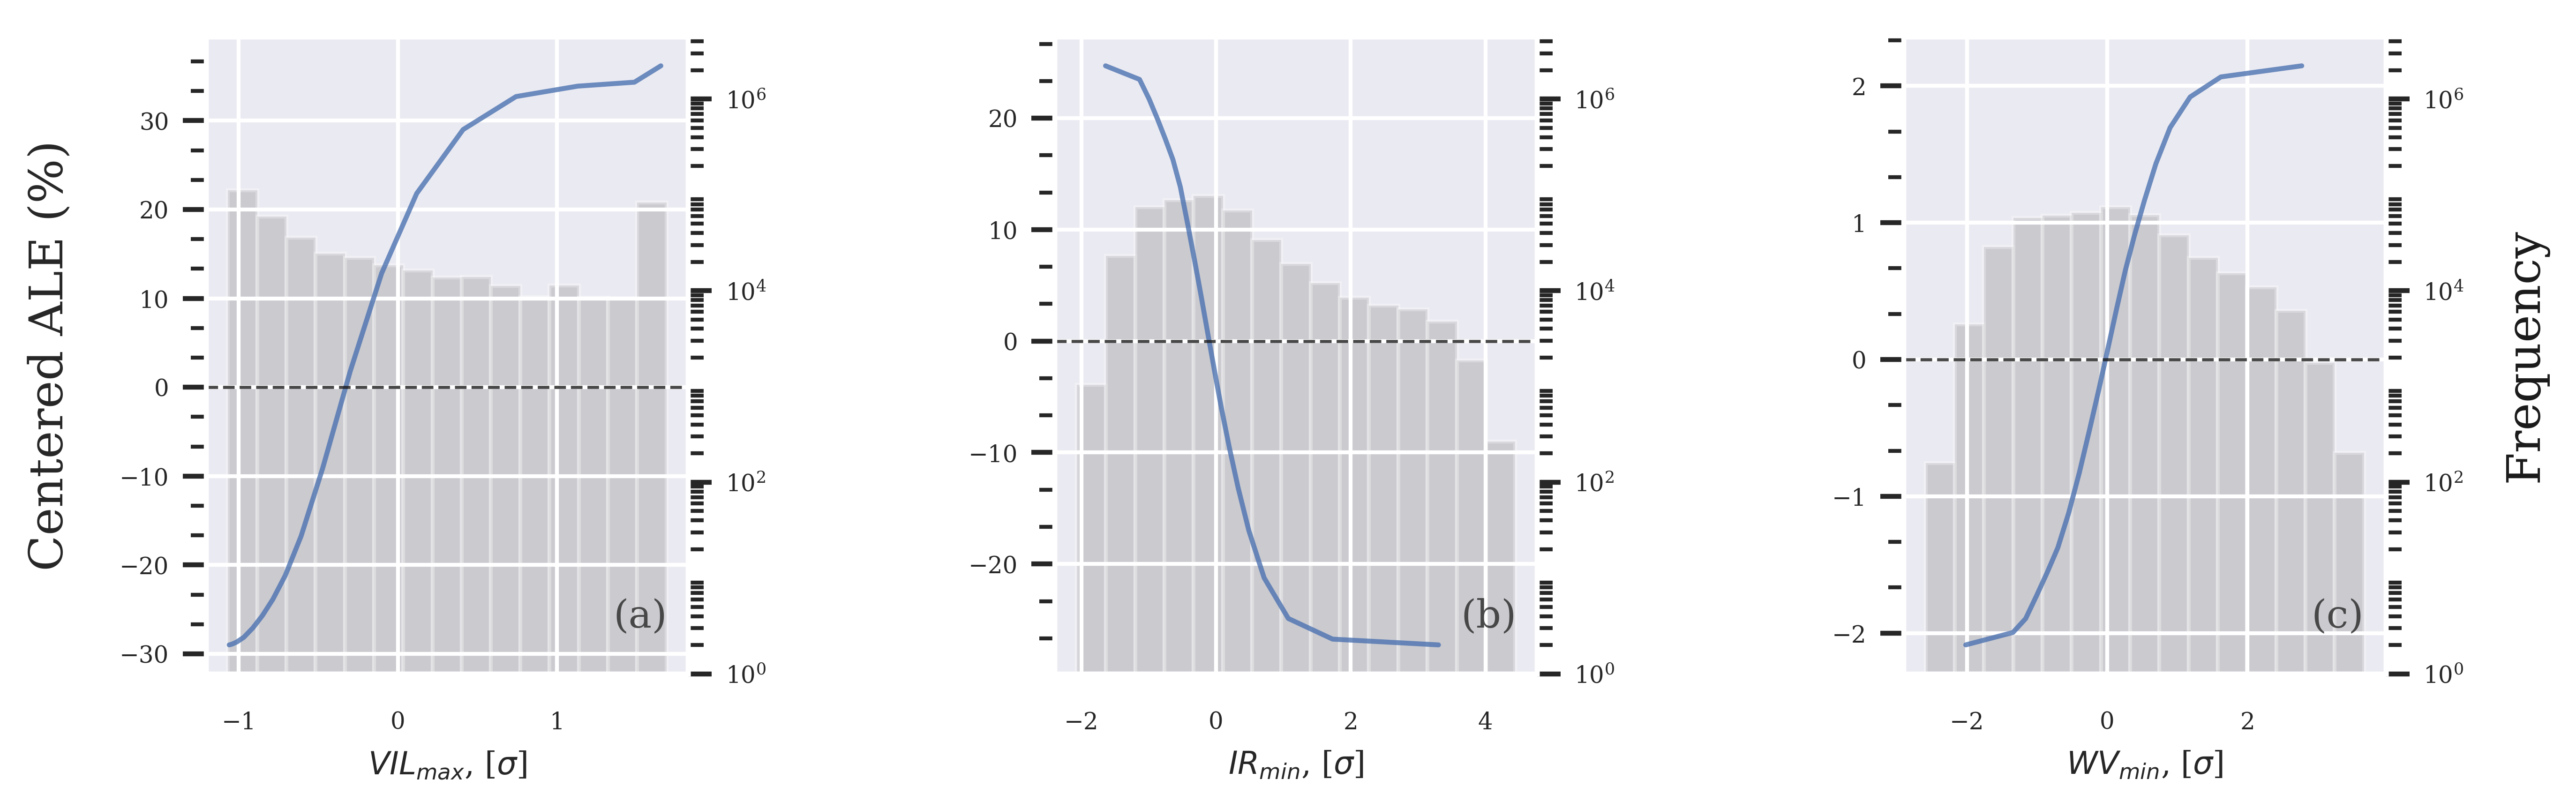

In [40]:
#plot the ALE
fig, axes = explainer.plot_ale(ale = ale_1d_ds,figsize=(10,3),hist_color = 'grey',line_kws={'line_colors':['b','r','g']})

#so we can copy paste, back the figure have a white background 
fig.set_facecolor('w')

#make xlabel more meaningful.
ax = axes[0]
ax.set_xlabel('$VIL_{max}$, [$\sigma$]')
ax = axes[1]
ax.set_xlabel('$IR_{min}$, [$\sigma$]')
ax = axes[2]
ax.set_xlabel('$WV_{min}$, [$\sigma$]')

For each subplot, the x-axis is the feautre being examined, the left y-axis is the accumulated local effects measurement, the right y-axis is the counts in each bin (corresponding to the histogram in the back), the line is accumulated local effects measurement and the histogram is the binned counts that are used to make the accumulated local effects measurement.

You might be wondering, "those don't look like the right units for those variables.." and you are right. Remember that we scaled our data to have mean 0 and a variance of 1. So this transformation can be thought of the number of standard deviations ($\sigma$) from the mean (value of 0). 

Let's interpret one now, panel (a). We can see that as we go from a standard deviation less than the mean to about a standard deviation above the mean, the probability of a storm image containing lightning changes drastically. Which makes sense, larger $\mathrm{VIL_{max}}$ means stronger storms and thus better chance at lightning. Moving on to panel (b) we see that for lower brightness temperatures at infrared, there is a larger chance at the image containing lightning. Lastly, water vapor has a bit of an unexpected trend (panel c). It has the opposite of what I would expect, showing larger brightness temperatures at the water vapor chanel shows better chance at lightning. While I am unsure if this is physical, see the relative magnitude of this feaure is 10x less than the previous two, so it looks to be a weaker impact to the overall prediciton. 

One thing that could be helpful is to convert the x-axis back into their normal units. This should give a bit more perspective. 

Text(0.5, 0, '$WV_{min}$, [$^{\\circ}$C]')

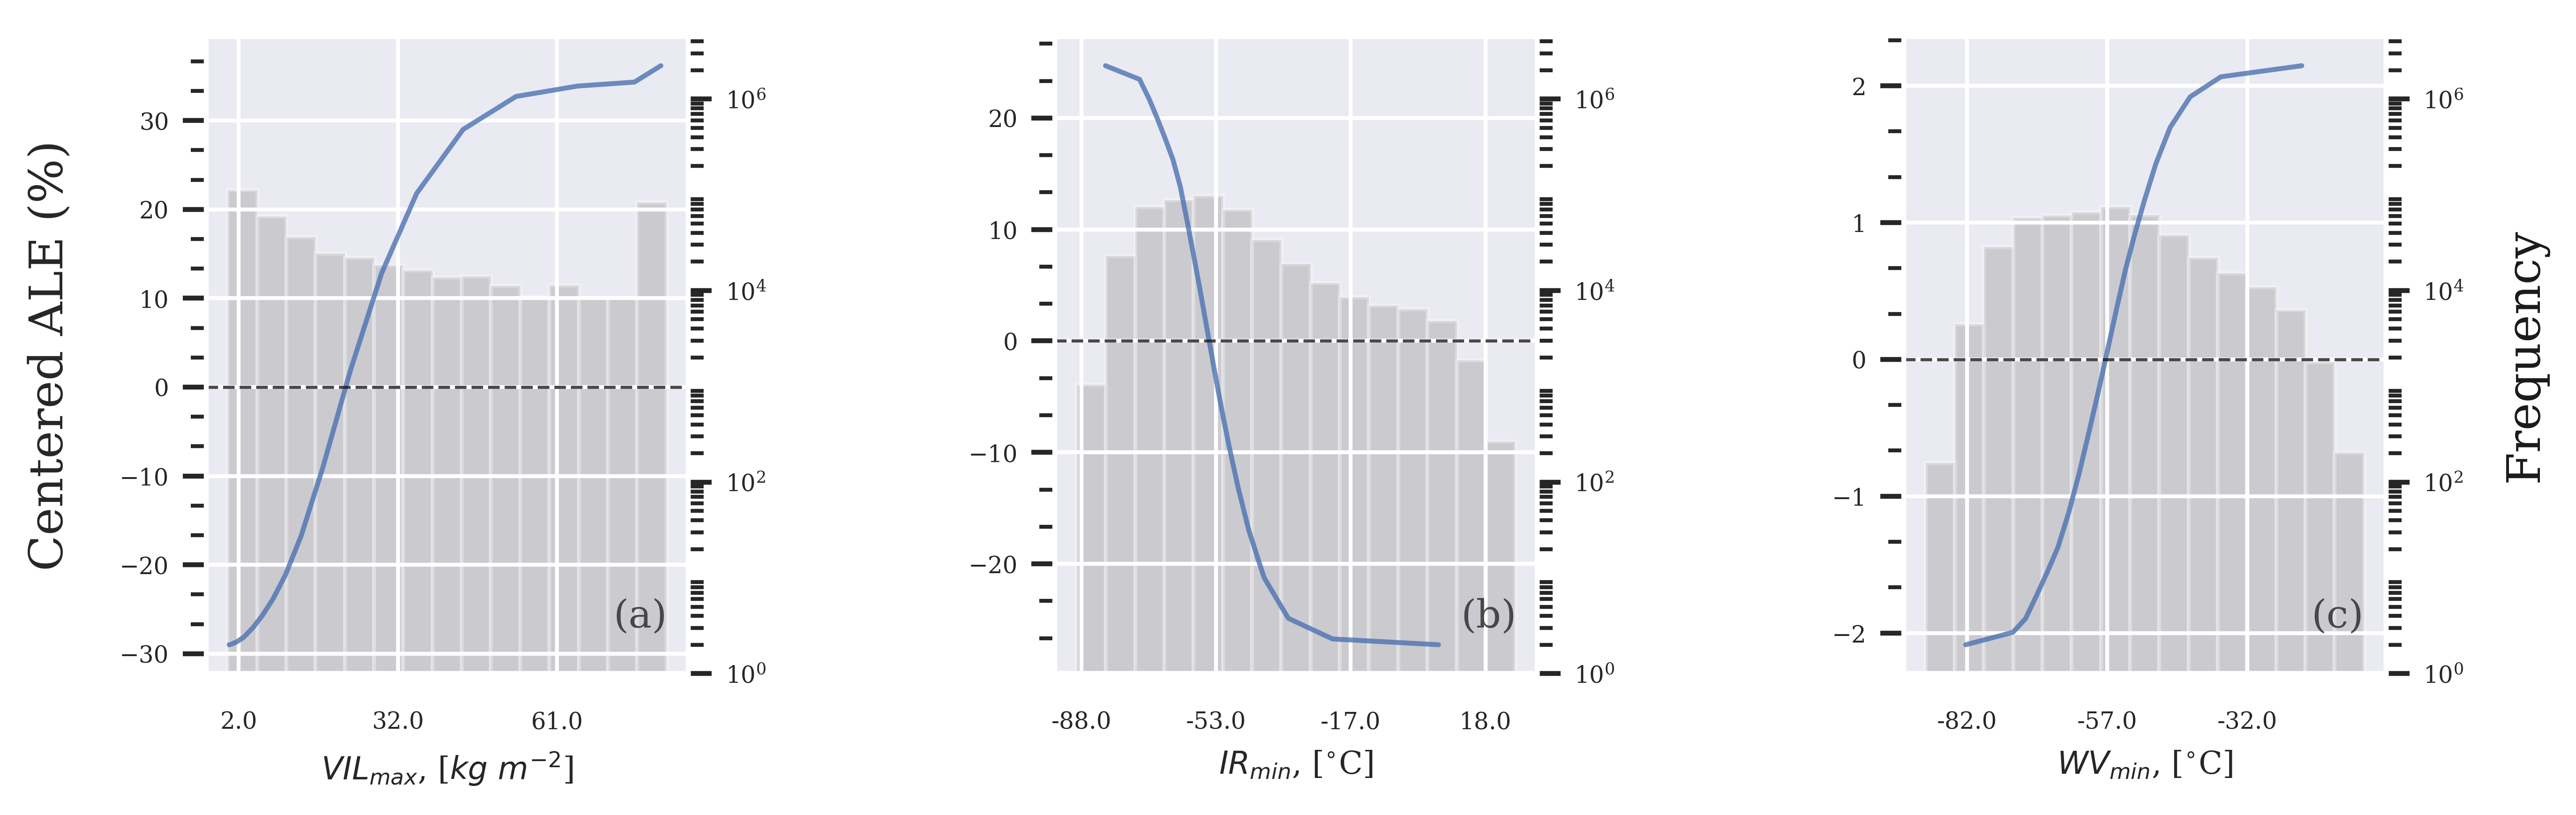

In [41]:
fig, axes = explainer.plot_ale(ale = ale_1d_ds,figsize=(10,3),hist_color = 'grey',line_kws={'line_colors':['b','r','g']})
fig.set_facecolor('w')

#I do have to adjust
ax = axes[0]
xticks = ax.get_xticks()
#scale back using the scaler object, .scale is the standard deviation while .mean is the mean
xlabels = np.round(xticks*scaler.scale_[-1] + scaler.mean_[35])
ax.set_xticklabels(xlabels)
ax.set_xlabel('$VIL_{max}$, [$kg \ m^{-2}$]')

ax = axes[1]
xticks = ax.get_xticks()
#scale back 
xlabels = np.round(xticks*scaler.scale_[0] + scaler.mean_[0])
ax.set_xticklabels(xlabels)
ax.set_xlabel('$IR_{min}$, [$^{\circ}$C]')


ax = axes[2]
xticks = ax.get_xticks()
#scale back 
xlabels = np.round(xticks*scaler.scale_[9] + scaler.mean_[9])
ax.set_xticklabels(xlabels)
ax.set_xlabel('$WV_{min}$, [$^{\circ}$C]')

The interpretation is largely the same, but the true units make a bit more sense to me

Let's look at the same 3 models we looked at in the permutation importance test. 

In [42]:
#redefine estimators so we can just look at 1 machine learning model right now 
estimators = estimators = [('LogisticRegression',model_list[0]),('RandomForest',model_list[3]),('GradientBoostedTrees',model_list[4])]
explainer = skexplain.ExplainToolkit(estimators=estimators, X=X_df, y=y_validate,)
#these are the keys for VIL_max, IR_min and WV_min
ale_1d_ds = explainer.ale(features=['q100_vl','q000_ir','q000_wv'],n_bootstrap=1,subsample=1000,n_jobs=1, n_bins=20)

  0%|          | 0/9 [00:00<?, ?it/s]

Text(0.5, 0, '$WV_{min}$, [$^{\\circ}$C]')

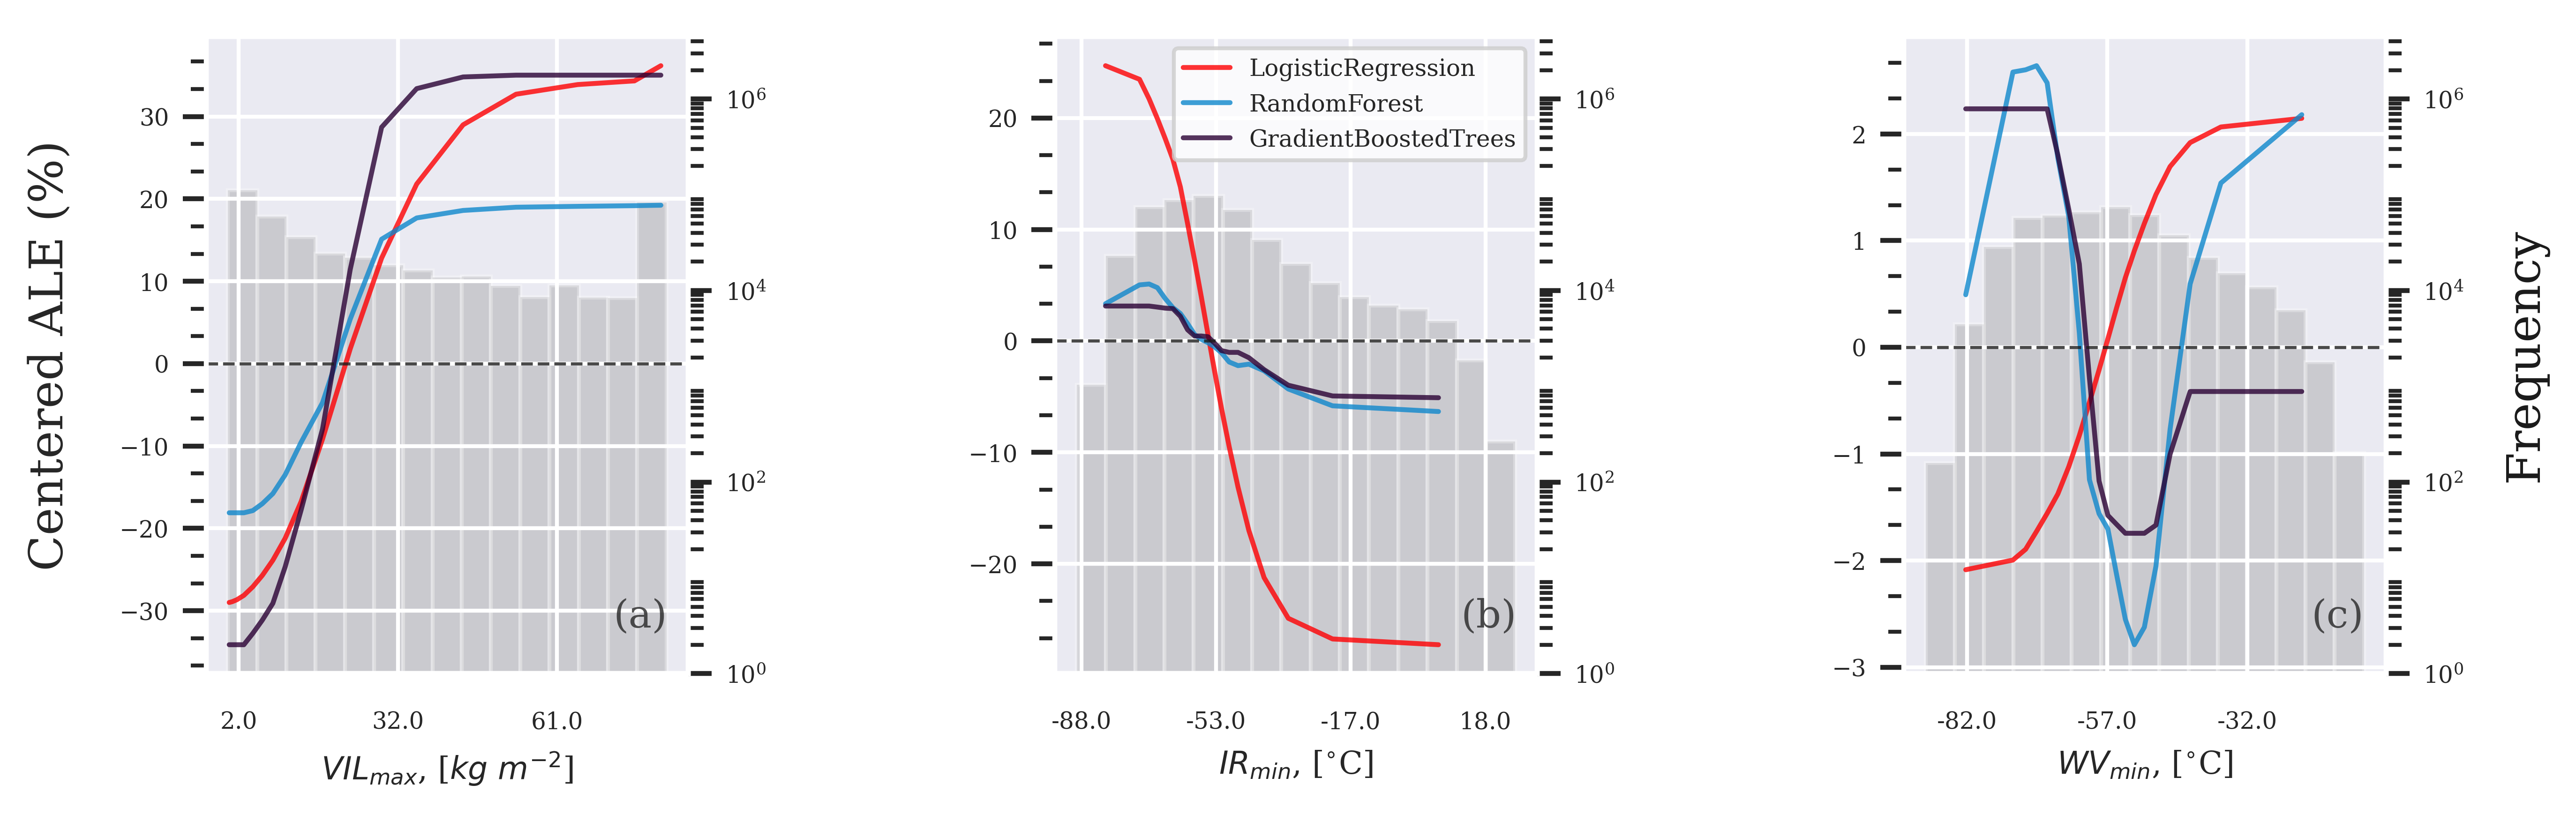

In [48]:
fig, axes = explainer.plot_ale(ale = ale_1d_ds,figsize=(10,3),hist_color = 'grey',line_colors = ['blue','red','green'])
fig.set_facecolor('w')

#I do have to adjust
ax = axes[0]
xticks = ax.get_xticks()
#scale back using the scaler object, .scale is the standard deviation while .mean is the mean
xlabels = np.round(xticks*scaler.scale_[-1] + scaler.mean_[35])
ax.set_xticklabels(xlabels)
ax.set_xlabel('$VIL_{max}$, [$kg \ m^{-2}$]')

ax = axes[1]
xticks = ax.get_xticks()
#scale back 
xlabels = np.round(xticks*scaler.scale_[0] + scaler.mean_[0])
ax.set_xticklabels(xlabels)
ax.set_xlabel('$IR_{min}$, [$^{\circ}$C]')
leg = ax.legend(loc=1)
leg.get_frame().set_facecolor('w')


ax = axes[2]
xticks = ax.get_xticks()
#scale back 
xlabels = np.round(xticks*scaler.scale_[9] + scaler.mean_[9])
ax.set_xticklabels(xlabels)
ax.set_xlabel('$WV_{min}$, [$^{\circ}$C]')



For the $\mathrm{VIL_{max}}$, all trained models here look to show the same relative pattern. Increasing $\mathrm{VIL_{max}}$, increases the machine learning prediction of the image having lightning. Same for the $\mathrm{IR_{min}}$, lower brightness temperatures has a higher confidence of an image having lightning. Panel (c) is an interesting one. Random forest and gradient boosted trees show a simular oscilation from high ALE for brightness temperatures. But as we said before, the relative ALE value and the permutation importance result shows $\mathrm{WV_{min}}$ might be important, but it is not nearly as important as the $\mathrm{VIL_{max}}$. 

While we showed these methods for our classification, you can do it with Regression! So feel free to load the regression data and do the same analysis!